# Pipeline
Featured in this notebook is the desired pipeline towards anomaly recognition.

## Imports and other needed things

In [1]:
#!pip install ultralytics

In [2]:
from google.colab import drive
from google.colab import files
from google.cloud import storage
drive.mount('/content/drive')

# Imports
#Standard Library Imports
import os, io
import time
from io import BytesIO
import random
import json

#Third party imports
from google.cloud import storage

import pandas as pd
import numpy as np
import cv2

import torch

from skimage.io import imread
from skimage.transform import resize

from matplotlib import pyplot as plt
import skimage
from PIL import Image

# To be able to run models
from ultralytics import YOLO
from keras.models import load_model
import tensorflow as tf
import unet_build_blocks
import build_unet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load in Models
- YOLOv8 : Object Detection
- Autoencoder : Anomaly Detection
- U-Net : Anomaly Segmentation
( Due to issues with how the U-Net is implemented, loading the state dictionary of the model is required.)

In [3]:
#Load YOLO model
object_detection_model = YOLO('waymo_trained_yolo_v8.pt', task='detect')
object_detection_model.conf = 0.3

In [4]:
anomaly_detection_model= tf.keras.models.load_model('auto_encoder')

In [17]:
# Assuming this is your script to build the UNet model
segmentation_model  = build_unet.build_unet()

# Load the saved state dictionary
saved_state_dict = torch.load("segmentation_model_V3_state_dict.pt", map_location=torch.device('cpu'))

# Get the state dictionary of the model
model_state_dict = segmentation_model.state_dict()

# Map keys from saved_state_dict to model_state_dict
new_state_dict = {k: v for k, v in saved_state_dict.items() if k in model_state_dict}

# Update the model's state dictionary with the new_state_dict
model_state_dict.update(new_state_dict)

# Load the updated state dictionary into the model
segmentation_model.load_state_dict(model_state_dict)


<All keys matched successfully>

## Load in a Sample Image
The IMAGE_FILE variable can be replaced, but the image loaded is one that'll run through the whole notebook.

In [6]:
IMAGE_FILE = "test.jpg"

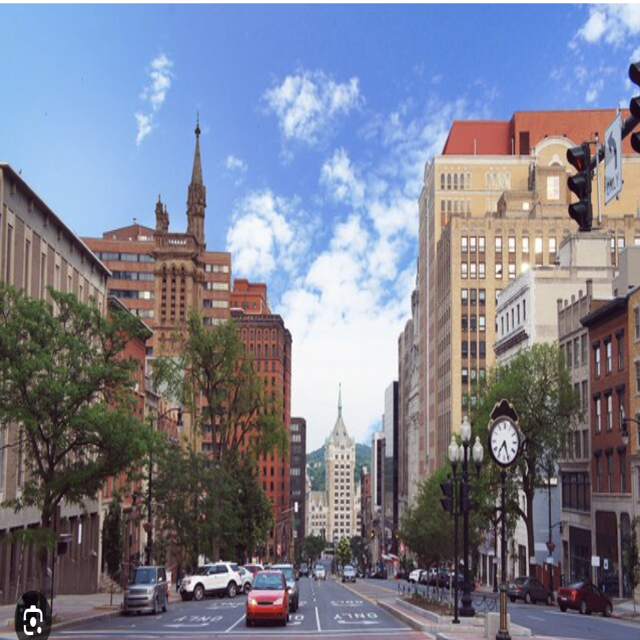

In [7]:
# We have a test image you can use called "test.jpg"
# Otherwise, use an image of your own!

input_image = Image.open(IMAGE_FILE).resize((640,640))
input_image

## Step 1. Object Detection Model
- Preprocess images into appropiate format
- Get output of input images from YOLOv8 model
- Save a resulted image with appropiate masked bounded boxes

In [8]:
results = object_detection_model(input_image)
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.save('results.jpg')  # save image
    box_info = pd.DataFrame(r.boxes.xywh.numpy())
box_info = box_info.rename(columns={0:'center_x',1:'center_y',2:'size_x',3:'size_y'})


0: 640x640 4 vehicles, 334.5ms
Speed: 8.6ms preprocess, 334.5ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)


This is what the yolo image looks like! Neat, huh? Not so neat if there isn't typical street things. Like, if there's a sheep, no boxes.

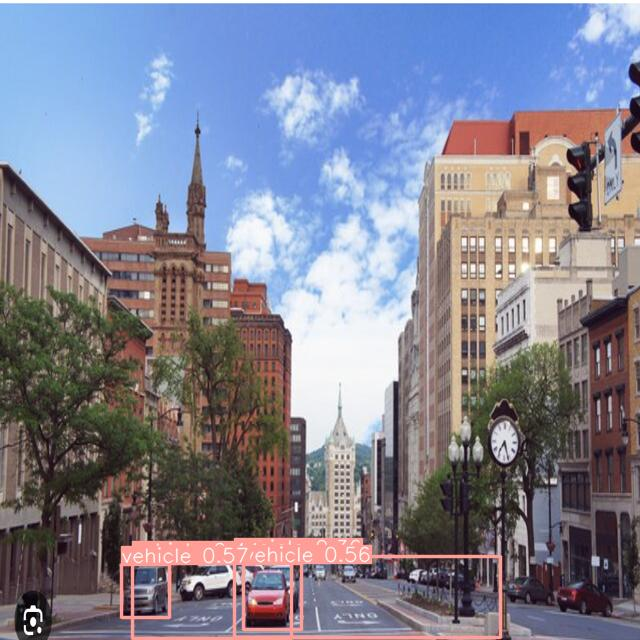

In [9]:
Image.open('results.jpg')

### Helper functions to preprocess the YOLO image

In [10]:
# this effectively converts all pixels within the bounding box into black pixels
def blackout_bounding_boxes(df, image_array):
    for index, row in df.iterrows():
        center_x = int(row['center_x'])
        center_y = int(row['center_y'])
        width = int(row['size_x'])
        height = int(row['size_y'])

        x1 = int(center_x - width / 2)
        y1 = int(center_y - height / 2)
        x2 = int(center_x + width / 2)
        y2 = int(center_y + height / 2)

        image_array[y1:y2, x1:x2] = 0

    return image_array

## Step 2. Anomaly Detection Model
- Be sure resulted image from step 2 is in appropiate format.
- Input result in autoencoder model
- Save result of whole image with regions masked that don't contain anomlous regions

1/1 [==============================] - 2s 2s/step


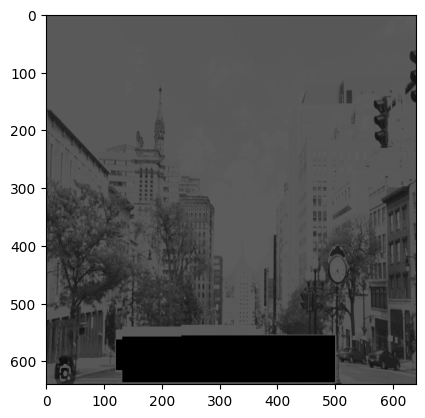

In [18]:
blackout_array = Image.fromarray(blackout_bounding_boxes(box_info,im_array[..., ::-1])).convert('L')

img_array = np.array(blackout_array)  / 255.0
img_array = np.expand_dims(img_array, axis= 0)
img_array = np.expand_dims(img_array, axis=-1)

tensor_array = tf.convert_to_tensor(img_array, dtype=tf.float32)

output = anomaly_detection_model.predict(tensor_array)

plt.imshow(output[0],cmap='gray',vmin=0, vmax=1)

Look at that reconstructed image from our beloved autoencoder!

Now lets compare with the image that we input so we can how well the reconstruction worked...

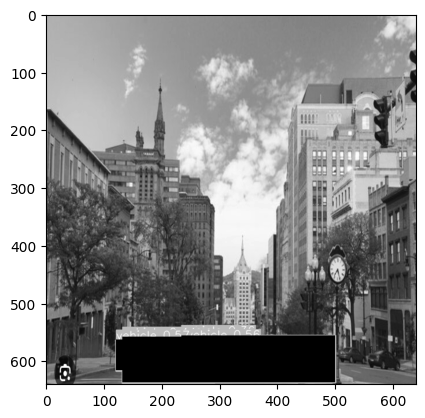

In [19]:
plt.imshow(img_array[0],cmap='gray',vmin=0, vmax=1)

Not bad! Let's move on and get some numbers.

### MSE Information
After the image is reconstructed, we want to gather MSE values. This involves a comparison of the original image and the reconstructed. We're going to split the images into (64x64) tiles first, hence the defining function below. This function works best for arrays with a channel defined in their shape.

In [20]:
def split_and_stack_image(image_array, output_shape=(64, 64)):
    input_height, input_width,_ = image_array.shape
    num_rows = input_height // output_shape[0]
    num_cols = input_width // output_shape[1]
    stacked_images = []
    for i in range(num_rows):
        for j in range(num_cols):
            start_row = i * output_shape[0]
            end_row = start_row + output_shape[0]
            start_col = j * output_shape[1]
            end_col = start_col + output_shape[1]
            small_image = image_array[start_row:end_row, start_col:end_col]
            stacked_images.append(small_image)
    stacked_array = np.stack(stacked_images, axis = 0)
    return stacked_array

split_array_before = split_and_stack_image(img_array[0])
split_array_after = split_and_stack_image(output[0])

mse = tf.keras.losses.MeanSquaredError()
mse_values = []
for i, _ in enumerate(split_array_before):
  mse_values.append(mse(split_array_before[i],split_array_after[i]).numpy())

Now, taken from our evaluation, we have some mean and standard deviation values from a json file to use in order to determine z-scores

In [21]:
#Import the json file - this should be located in the repo
stat_info = json.load(open("distribution_metrics.json"))

# Calculate mean and standard deviation
mean = float(stat_info['mean'])
std_dev = float(stat_info['deviation'])

# Calculate z-scores
z_scores = np.array([(z - mean) / std_dev for z in mse_values])

# Set a threshold (e.g., 2 standard deviations)
threshold = 0

# Identify anomalies
non_anomalies = np.where(z_scores < threshold)[0]
anomalies = np.where(z_scores > threshold)[0]

print("Count of Non-Anomaly Tiles: ",len(non_anomalies))
print("Count of Anomaly Tiles: ",len(anomalies))
print("Indicies: ", anomalies)

Count of Non-Anomaly Tiles:  97
Count of Anomaly Tiles:  3
Indicies:  [45 55 65]


## Step 3. Segmentation of Anomaly
- Be sure resulted image from step 3 is in appropiate format
- Input result into U-Net model
- Save result and overlay over original image

After this editted function, we then proceed to try and run Segmentation on each tile that registers as anomalous. This way, we can try and pinpoint object down to the pixel. It involves splitting up the original image and recognizing those anomaly indicies from above, then if the index matches, we run the model.

It's much more memory friendly to run the model this way as well.

In [22]:
# An editted split and stack image for those images without channel numbers
def split_and_stack_image(image_array, output_shape=(64, 64)):
    input_height, input_width, = image_array.shape
    num_rows = input_height // output_shape[0]
    num_cols = input_width // output_shape[1]
    stacked_images = []
    for i in range(num_rows):
        for j in range(num_cols):
            start_row = i * output_shape[0]
            end_row = start_row + output_shape[0]
            start_col = j * output_shape[1]
            end_col = start_col + output_shape[1]
            small_image = image_array[start_row:end_row, start_col:end_col]
            stacked_images.append(small_image)
    stacked_array = np.stack(stacked_images, axis = 0)
    return stacked_array

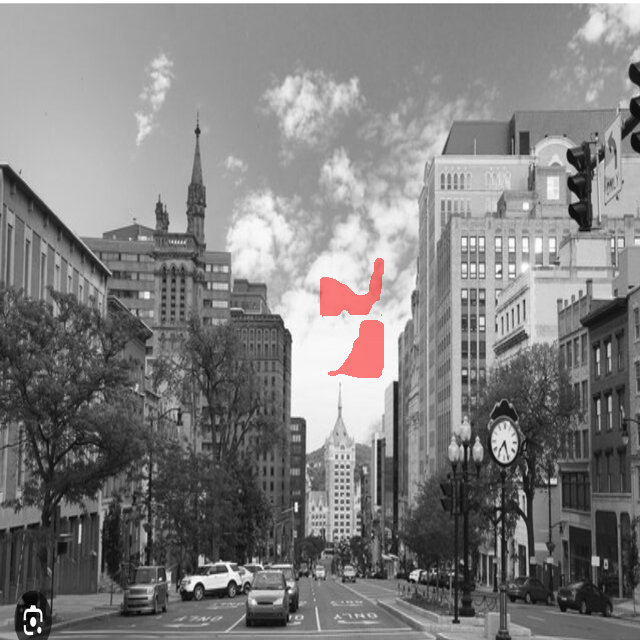

In [24]:
# Load the image using PIL
image = np.array(Image.open(IMAGE_FILE).convert("L").resize((640,640)))

# Load the cropped images (assuming you've saved them in a directory)
cropped_images = split_and_stack_image(image, output_shape=(64, 64))

# Convert cropped images to PyTorch tensors
cropped_tensors = [torch.tensor(cropped_image, dtype=torch.float32) for cropped_image in cropped_images]

# Convert grayscale image to RGB
rgb_image = np.stack((image,) * 3, axis=-1)

# Create the overlay color (e.g., red)
overlay_color = [255, 0, 0,128]

# Resize and place results on the original image only for anomalies
output_image = rgb_image.copy()  # Create a copy of the RGB image
anomaly_idx = 0  # Initialize anomaly index

for row in range(10):
    for col in range(10):
        start_row = row * 64
        end_row = start_row + 64
        start_col = col * 64
        end_col = start_col + 64

        # Check if the current row and column indices correspond to an anomaly
        if anomalies[anomaly_idx] == (row * 10 + col) and anomaly_idx < (len(anomalies)-1):

            cropped_image = cropped_images[anomalies[anomaly_idx]]
            cropped_tensor = cropped_tensors[anomalies[anomaly_idx]]
            model_result = segmentation_model(cropped_tensor.unsqueeze(0).unsqueeze(1))

            output_np = model_result[0].cpu().detach().numpy()

            # Threshold the output to create a binary mask
            threshold = 0.1
            binary_mask = (output_np > threshold).astype(np.uint8)

            # Overlay and highlight anomaly areas on the output image
            overlay_mask = cv2.resize(binary_mask.squeeze(), (cropped_image.shape[0], cropped_image.shape[1]))
            overlay = np.zeros((cropped_image.shape[0], cropped_image.shape[1],4), dtype=np.uint8)
            overlay[:, :, :3] = overlay_color[:3]
            overlay[:, :, 3] = overlay_color[3] * overlay_mask

            alpha = overlay[:, :, 3] / 255.0
            # Place the result onto the output image
            output_image[start_row:end_row,start_col:end_col,:] = (1 - alpha[:, :, np.newaxis]) * output_image[start_row:end_row, start_col:end_col, :] + alpha[:, :, np.newaxis] * overlay[:, :, :3]

            anomaly_idx += 1  # Move to the next anomaly index

# Display or save the output image
output_image = Image.fromarray(output_image)
output_image.save('output_image.jpg')  # Save the image
output_image  # Display the image

While not great, and if your image is a goat it may not be recognized, but this can be improved with further training of our models.